<a href="https://colab.research.google.com/github/Michele-Simeone/AILabProj-NBA-Scheme-Classification/blob/main/Code/ConvNexT_NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ConvNeXtTiny**

## **Import**

### **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Altri Import**

In [ ]:
!pip install tf-nightly
!pip install -U tensorflow-addons

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 583.6 MB 29 kB/s 
     |████████████████████████████████| 1.7 MB 47.0 MB/s 
     |████████████████████████████████| 439 kB 68.3 MB/s 
     |████████████████████████████████| 5.9 MB 46.4 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 22.9 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.11.0-dev20220908). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (64.0 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

## **Dataset**

### **Caricamento Dataset**

In [ ]:
train_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Train"
test_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Test"

#train_dir="/content/drive/MyDrive/LabIA/CNN/Train"
#test_dir="/content/drive/MyDrive/LabIA/CNN/Test"

batch_dim=8


train_generator = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        image_size=(256, 256),  
        batch_size=batch_dim,
        label_mode='int',
        seed=297,
        subset='training')

validation_generator =  tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        image_size=(256, 256),
        batch_size=batch_dim,
        label_mode='int',
        seed=297,
        subset='validation')

test_generator =  tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(256, 256),
        batch_size=batch_dim,
        label_mode='int')

Found 567 files belonging to 2 classes.
Using 454 files for training.
Found 567 files belonging to 2 classes.
Using 113 files for validation.
Found 186 files belonging to 2 classes.


### **Operazioni per Ottimizzazione della Memoria**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)


## **Funzione per disegnare le Learning Curves**

In [ ]:
def learning_curves(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']


  loss = history.history['loss']
  val_loss = history.history['val_loss']


  epochs = range(len(acc))


  plt.plot(epochs, acc,"tab:green", label="Training")
  plt.plot(epochs, val_acc,"tab:blue", label="Validation")
  plt.legend(loc="upper left")
  plt.title('Training and validation accuracy')

  plt.figure()


  plt.plot(epochs, loss,"tab:green", label="Training")
  plt.plot(epochs, val_loss,"tab:blue", label="Validation")
  plt.legend(loc="upper right")
  plt.title('Training and validation loss')


## **Model**

### **Base Model: Pre-Allenato**

In [ ]:
pre_model = tf.keras.applications.convnext.ConvNeXtTiny(input_shape=(256, 256, 3),
                                                        include_top=False,
                                                        include_preprocessing=True,
                                                        weights='imagenet',
                                                        classes=2,
                                                        pooling='avg')
pre_model.trainable = False

111650432/111650432 [==============================] - 4s 0us/step


### **Modello Completo**

In [ ]:
i_input = layers.Input(shape=(256, 256, 3))
x = pre_model(i_input,training=False)
x = layers.Dropout(0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'gelu')(x)

output = layers.Dense(1, activation='sigmoid')(x)

conv_model = Model(i_input, output)

conv_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 layer_normalization_2 (Laye  (None, 768)              1536      
 rNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                             

## **Compilazione**

In [ ]:
lr=0.001
wd=0.004
conv_model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.AdamW(learning_rate=lr,weight_decay=wd),
              metrics=['acc'])

## **Train**

In [ ]:
epoche=50
es=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc=ModelCheckpoint('/content/drive/MyDrive/LabIA/Best Model/best_conv_model.h5', monitor='val_accuracy', mode='max')

with tf.device('/gpu:0'):
  history_conv = conv_model.fit(
        train_generator,
        epochs=epoche,
        validation_data=validation_generator,
        callbacks=[mc,es])

Epoch 1/50
57/57 [==============================] - 167s 751ms/step - loss: 0.5458 - acc: 0.7291 - val_loss: 0.2681 - val_acc: 0.8938
Epoch 2/50
57/57 [==============================] - 7s 122ms/step - loss: 0.3101 - acc: 0.9009 - val_loss: 0.3395 - val_acc: 0.8407
Epoch 3/50
57/57 [==============================] - 7s 123ms/step - loss: 0.3039 - acc: 0.8987 - val_loss: 0.2734 - val_acc: 0.9027
Epoch 4/50
57/57 [==============================] - 7s 124ms/step - loss: 0.2951 - acc: 0.9207 - val_loss: 0.2289 - val_acc: 0.9469
Epoch 5/50
57/57 [==============================] - 7s 123ms/step - loss: 0.2894 - acc: 0.9141 - val_loss: 0.2198 - val_acc: 0.9558
Epoch 6/50
57/57 [==============================] - 7s 124ms/step - loss: 0.2787 - acc: 0.9273 - val_loss: 0.2256 - val_acc: 0.9646
Epoch 7/50
57/57 [==============================] - 7s 124ms/step - loss: 0.2892 - acc: 0.9053 - val_loss: 0.2304 - val_acc: 0.9558
Epoch 8/50
57/57 [==============================] - 7s 124ms/step - loss: 

### **Disegno Learning Curves**

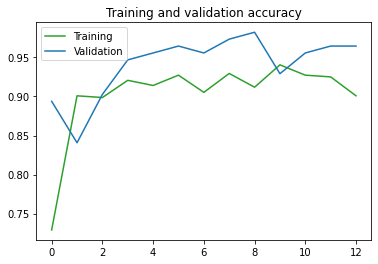

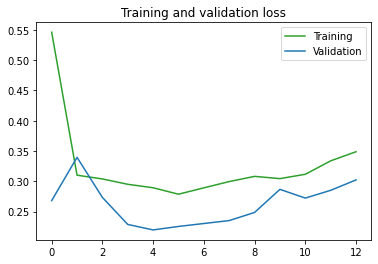

In [ ]:
learning_curves(history_conv)

## **Test**

In [ ]:
conv_model.load_weights("/content/drive/MyDrive/LabIA/Best Model/best_conv_model.h5")
results_conv = conv_model.evaluate(
      test_generator,
      batch_size=batch_dim)
print("test loss, test acc:", results_conv)

24/24 [==============================] - 83s 2s/step - loss: 0.4595 - acc: 0.7849
test loss, test acc: [0.4595085382461548, 0.7849462628364563]
